## Let's try to warp the point set for the entire myocardium, instead of 3 regional sets? 
## debugging why the regional point sets do not move to their ES position as shown in the model's ES segmentation output
## `N = 1`

In [1]:
model_name = "Original_Pretrained_R2plus1DMotionSegNet.pth"

# model_name = "dropout_v2_0_25_R2plus1DMotionSegNet.pth"
# model_name = "dropout_v3_0_10_R2plus1DMotionSegNet.pth"

In [2]:
import os
os.chdir("../..")
print(os.getcwd())

%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads, forgot to define in forward pass function, but still saw diff, weird.)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_50_R2plus1D_18_MotionNet import dropout_v2_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_75_R2plus1D_18_MotionNet import dropout_v2_0_75_R2plus1D_18_MotionNet
# v3 dropout (one dropout layer defined in forward pass func, this should've been the correct way to do it.)
from src.model.dropout_v3_0_00_R2plus1D_18_MotionNet import dropout_v3_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_10_R2plus1D_18_MotionNet import dropout_v3_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_25_R2plus1D_18_MotionNet import dropout_v3_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_50_R2plus1D_18_MotionNet import dropout_v3_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_75_R2plus1D_18_MotionNet import dropout_v3_0_75_R2plus1D_18_MotionNet
# v4 dropout (4 dropout layers in different places in the forward func, I'm going to guess more "generalizable")
from src.model.dropout_v4_0_00_R2plus1D_18_MotionNet import dropout_v4_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_10_R2plus1D_18_MotionNet import dropout_v4_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_25_R2plus1D_18_MotionNet import dropout_v4_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_50_R2plus1D_18_MotionNet import dropout_v4_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_75_R2plus1D_18_MotionNet import dropout_v4_0_75_R2plus1D_18_MotionNet

# for finding lv seg borders
import cv2 as cv

# for storing vector snapshots
import copy

# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

# full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
# random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking


100%|██████████| 16/16 [00:01<00:00, 13.71it/s]


In [3]:
model_save_path = f"save_models/{model_name}"
    
if model_name == 'Original_Pretrained_R2plus1DMotionSegNet.pth':
    model_template_obj = R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_00_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_10_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_10_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_25_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_25_R2plus1D_18_MotionNet()


elif model_name == "dropout_v3_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()


model = torch.nn.DataParallel(model_template_obj)

model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
model.eval();

Original_Pretrained_R2plus1DMotionSegNet.pth has 31575731 parameters.


In [4]:
from src.strain import *

In [5]:
%matplotlib widget

In [6]:
N = 1
test_pat_index = 0

curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label = get_seg_and_warp_data(model = model,
                                                                                            test_dataset = test_dataset,
                                                                                            test_pat_index = test_pat_index)
    
ed_raw_seg_out = curr_clip_segmentations[:,0,...]

ed_one_hot_seg_out = one_hot(ed_raw_seg_out)

In [31]:
def image_to_whole_point_set(I):
    '''
    I - (112, 112) whole image segmentation
    points - (N, 2) stored in x, y
    '''
    I = give_boundary_no_basal_plane(I)
    points = []
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i][j] == 1:
                points.append(np.array([j, i]))
    return np.array(points)

In [47]:
def vis_single_point_set(ps):
    ''' ps - (N, 2) stored in (x,y)'''
    f, ax = plt.subplots(1, 1, figsize=(4, 5))
    ax.scatter(ps[:, 0], ps[:, 1], marker='.', color='b')
    ax.invert_yaxis()

In [48]:
I = ed_one_hot_seg_out
# I = ed_label

# I_regional_point_sets = image_to_regional_point_sets(I, N)
I_point_set = image_to_whole_point_set(I)

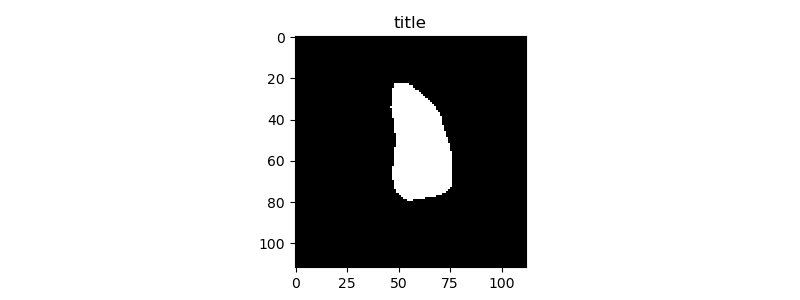

In [49]:
vis_single(I, cmap='gray')

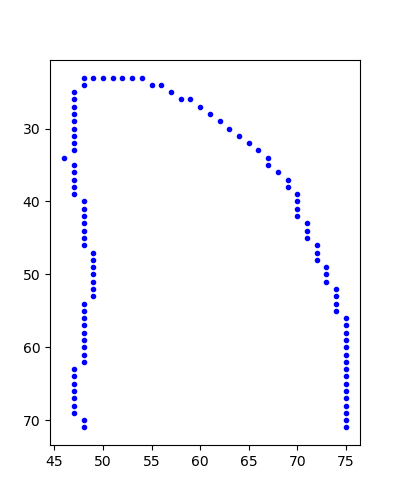

In [50]:
# vis_three_point_sets(I_regional_point_sets)
vis_single_point_set(I_point_set)

In [55]:
I_point_set.shape

(105, 2)

## loop over the single point set
## Apply warp from `ED` to `ES` frame for all points in this point set.

In [ ]:
# for a single point set

# warp forward one frame, don't need to interpolate
for point in I_point_set:
    # start with just the x,y position
    v = Vector(point[0], point[1], 0, 0)
    
    # get the change in position and 
    

In [51]:
# all_point_sets_vectors = []

# for POINT_SET_IND in range(N):
#     # get point set
#     I_curr_point_set = I_regional_point_sets[POINT_SET_IND]
#     coords = I_curr_point_set
#     coords_multiple_frames = np.array([coords]).astype(float)
    
#     # warp one frame forward
#     coords_multiple_frames = preliminary_warp_one_vector_forward(coords_multiple_frames, curr_clip_motions)
    
#     # warp the rest of the frames forward
#     point_set_all_vectors = []

#     for ind_of_point_to_warp in range(coords_multiple_frames.shape[1]):
#         all_new_vectors = warp_one_vector_forward_till_ES(coords_multiple_frames, ind_of_point_to_warp, delta_ed_es, curr_clip_motions)
#         point_set_all_vectors.append(all_new_vectors)
        
#     # save all the vectors for this point set
#     all_point_sets_vectors.append(point_set_all_vectors)

## Now, reconstruct and plot the auto-seg warped apical point set at the `ES` frame -- compare it to the auto-seg out `ES` frame apical point set

In [52]:
I_ES_regional_point_sets = [] # stored in x,y format

for i in range(N):
    curr_points = []
    
    # get all the vectors/points
    foo = all_point_sets_vectors[i]
    
    # within all the vectors/points, we stored snapshots of this point across frames, we want the last one
    for vectors in foo:
        v = vectors[-1]
        p = [v.tail_x, v.tail_y]
        curr_points.append(p)
    curr_points = np.array(curr_points)
    I_ES_regional_point_sets.append(curr_points)
    
I_ES_regional_point_sets = np.array(I_ES_regional_point_sets)

In [53]:
I_ES_regional_point_sets.shape

(1, 24, 2)

IndexError: index 1 is out of bounds for axis 0 with size 1

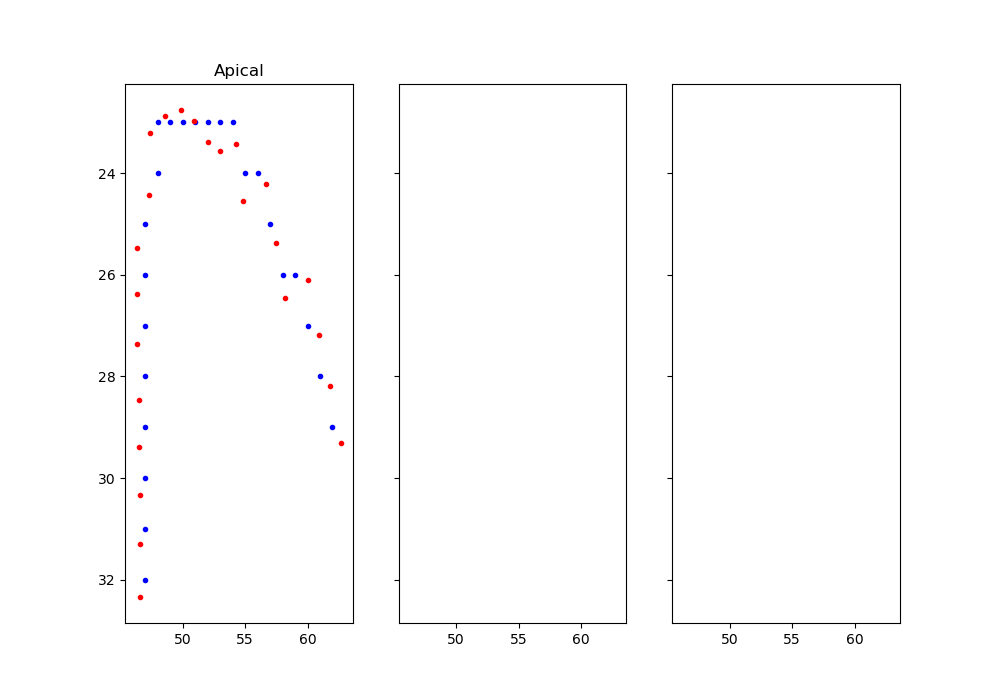

In [54]:
vis_double_three_point_sets(I_regional_point_sets, new_regional_point_sets=I_ES_regional_point_sets, title='ED Blue | ES Red')

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking/src/strain.py:1150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  I_regional_point_sets = np.array(I_regional_point_sets)


IndexError: index 1 is out of bounds for axis 0 with size 1

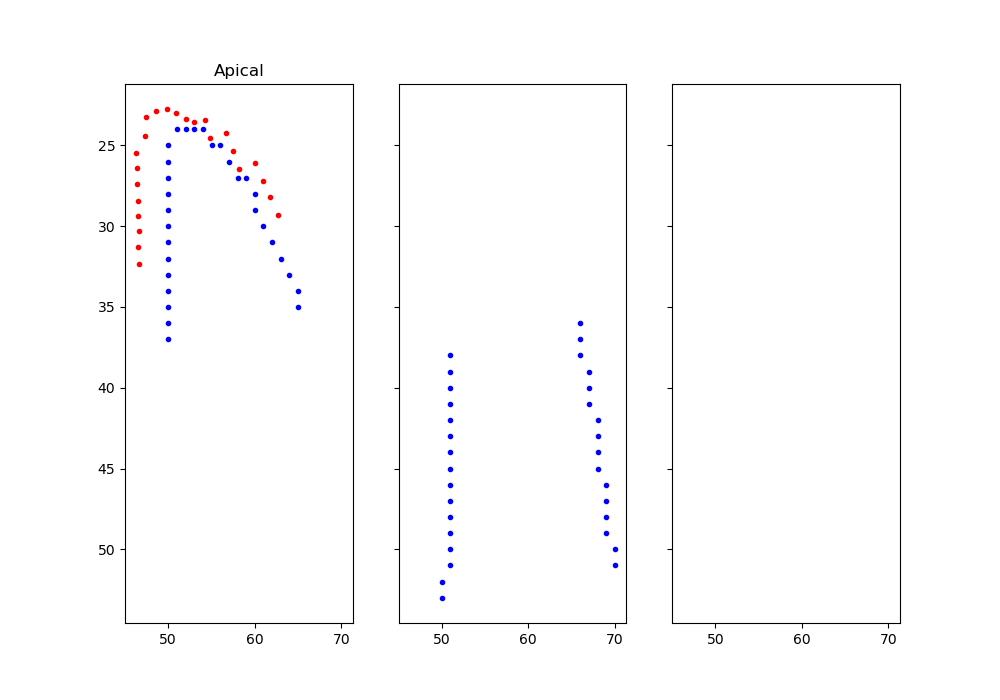

In [19]:
# we should compare the warp_ES point set against the es_label point set now

es_raw_seg_out = curr_clip_segmentations[:,delta_ed_es,...]

es_one_hot_seg_out = one_hot(es_raw_seg_out)


es_auto_seg_point_set = image_to_regional_point_sets(es_one_hot_seg_out)

vis_double_three_point_sets(es_auto_seg_point_set, new_regional_point_sets=I_ES_regional_point_sets, title='ES Auto Seg Blue | Warped ES from ED Auto Seg Red')